# Pacbio consensus UMI
This notebook calls consensus muations on PacBio data grouped by by cell_barcode, gene, and UMI. Then, it exports a processed CSV with the following columns:
* cell_barcode
* gene
* UMI
* mutation
* mutation_CCS

In [45]:
import Bio.Seq
import Bio.SeqIO

from IPython.display import display

from dms_variants.constants import CBPALETTE

import numpy as np

import pandas as pd

import plotnine as p9

In [35]:
consensus_UMI_csv = snakemake.input.consensus_UMI_csv
viral_genbank = snakemake.input.viral_genbank
expt = snakemake.wildcards.expt
consensus_gene_csv = snakemake.output.consensus_gene_csv

AttributeError: 'InputFiles' object has no attribute 'viral_genbank'

Style parameters:

In [4]:
p9.theme_set(p9.theme_classic())

## Load Data

In [5]:
mutations = pd.read_csv(consensus_UMI_csv)
mutations['mutation'] = mutations['mutation'].fillna('None')
display(mutations)

,cell_barcode,gene,UMI,mutation
0,GCCCAGACAATTTCTC,fluNP,TTGATCGATCTA,G1498A
1,GCCCAGACAATTTCTC,fluNP,TTGATCGATCTA,del1382to1382
2,GCCCAGACAATTTCTC,fluNP,TTGATCGATCTA,ins1498C
3,GCAACATTCGTAACAC,fluNP,GAAGCAATTCAT,WT
4,CGATGCGAGATGCGAC,fluNP,ACTTGTCTAAAG,del1495to1498
...,...,...,...,...
721534,CACAGGCGTCCCTAAA,fluHA,AATACGCGCATA,del166to166
721535,CACAGGCGTCCCTAAA,fluHA,AATACGCGCATA,del237to237
721536,CACAGGCGTCCCTAAA,fluHA,AATACGCGCATA,del895to895
721537,CACAGGCGTCCCTAAA,fluHA,AATACGCGCATA,del963to963


## Process Data

Generate list of all cell_barcode-gene:

In [6]:
cb_gene = (
    mutations
    [['cell_barcode',
      'gene']]
    .drop_duplicates()
)
display(cb_gene)

,cell_barcode,gene
0,GCCCAGACAATTTCTC,fluNP
3,GCAACATTCGTAACAC,fluNP
4,CGATGCGAGATGCGAC,fluNP
5,TCGGGCACACATATCG,fluNP
7,TGTGGCGAGGTGATAT,fluNP
...,...,...
712216,CGTAGTAAGGCAGTCA,fluHA
712559,CCTCCAAGTGCTTATG,fluHA
712608,TTAGGCAAGATTGACA,fluHA
712765,AGAGAGCAGCGCGTTC,fluHA


Count total UMI for cell_barcode-gene:

In [7]:
total_UMI_df = (
    mutations
    .groupby(['cell_barcode', 'gene'])
    ['UMI']
    .nunique()
    .reset_index()
    .rename(columns={'UMI': 'total_UMI'}))
display(total_UMI_df)

,cell_barcode,gene,total_UMI
0,AAACGAAGTACTTCCC,fluM,660
1,AAACGAAGTACTTCCC,fluNA,152
2,AAACGAAGTACTTCCC,fluNP,1169
3,AAACGAAGTACTTCCC,fluNS,673
4,AAACGAAGTACTTCCC,fluPA,3
...,...,...,...
2964,TTTGGAGGTATCGTTG,fluNP,348
2965,TTTGGAGGTATCGTTG,fluNS,167
2966,TTTGGAGGTATCGTTG,fluPA,6
2967,TTTGGAGGTATCGTTG,fluPB1,23


Exclude WT UMI:

In [8]:
mutations_noWT = mutations.query('mutation != "WT"')

display(mutations_noWT)

,cell_barcode,gene,UMI,mutation
0,GCCCAGACAATTTCTC,fluNP,TTGATCGATCTA,G1498A
1,GCCCAGACAATTTCTC,fluNP,TTGATCGATCTA,del1382to1382
2,GCCCAGACAATTTCTC,fluNP,TTGATCGATCTA,ins1498C
4,CGATGCGAGATGCGAC,fluNP,ACTTGTCTAAAG,del1495to1498
5,TCGGGCACACATATCG,fluNP,ATGATATAATTA,del1340to1498
...,...,...,...,...
721533,TATTTCGGTGCCTAAT,fluHA,ACGCACCCGATT,T742G
721534,CACAGGCGTCCCTAAA,fluHA,AATACGCGCATA,del166to166
721535,CACAGGCGTCCCTAAA,fluHA,AATACGCGCATA,del237to237
721536,CACAGGCGTCCCTAAA,fluHA,AATACGCGCATA,del895to895


Count number of UMI supporting each mutation for cell_barcode-gene:

In [9]:
mutation_UMI_df = (
    mutations_noWT
    .groupby(['cell_barcode', 'gene', 'mutation'])
    ['UMI']
    .nunique()
    .reset_index()
    .rename(columns={'UMI': 'mutation_UMI'}))
display(mutation_UMI_df)

,cell_barcode,gene,mutation,mutation_UMI
0,AAACGAAGTACTTCCC,fluM,A103G,1
1,AAACGAAGTACTTCCC,fluM,A111C,1
2,AAACGAAGTACTTCCC,fluM,A119G,1
3,AAACGAAGTACTTCCC,fluM,A180G,1
4,AAACGAAGTACTTCCC,fluM,A208G,3
...,...,...,...,...
172719,TTTGGAGGTATCGTTG,fluPB1,T1408C,1
172720,TTTGGAGGTATCGTTG,fluPB1,T1971C,1
172721,TTTGGAGGTATCGTTG,fluPB1,del1483to1483,2
172722,TTTGGAGGTATCGTTG,fluPB1,del1957to1957,1


Bring in total UMI counts and calculate fraction of total UMI with each mutation:

In [10]:
mutation_frac_df = pd.merge(
    left=mutation_UMI_df,
    right=total_UMI_df,
    on=['cell_barcode', 'gene'],
    how='left',
    validate='many_to_one')
mutation_frac_df['frac_UMI'] = (
    mutation_frac_df['mutation_UMI'] /
    mutation_frac_df['total_UMI']
)
display(mutation_frac_df)

,cell_barcode,gene,mutation,mutation_UMI,total_UMI,frac_UMI
0,AAACGAAGTACTTCCC,fluM,A103G,1,660,0.001515
1,AAACGAAGTACTTCCC,fluM,A111C,1,660,0.001515
2,AAACGAAGTACTTCCC,fluM,A119G,1,660,0.001515
3,AAACGAAGTACTTCCC,fluM,A180G,1,660,0.001515
4,AAACGAAGTACTTCCC,fluM,A208G,3,660,0.004545
...,...,...,...,...,...,...
172719,TTTGGAGGTATCGTTG,fluPB1,T1408C,1,23,0.043478
172720,TTTGGAGGTATCGTTG,fluPB1,T1971C,1,23,0.043478
172721,TTTGGAGGTATCGTTG,fluPB1,del1483to1483,2,23,0.086957
172722,TTTGGAGGTATCGTTG,fluPB1,del1957to1957,1,23,0.043478


**Call Consensus Mutations**  
Label mutation as consensus if it is found in more than half of UMIs and at least 2 UMIs. These correspond to `frac_UMI > 0.5` and `mutation_UMI >= 2` in our dataframe.

In [11]:
mutation_frac_df['consensus'] = (
    (mutation_frac_df['frac_UMI'] > 0.5) & 
    (mutation_frac_df['mutation_UMI'] >= 2))
display(mutation_frac_df)

,cell_barcode,gene,mutation,mutation_UMI,total_UMI,frac_UMI,consensus
0,AAACGAAGTACTTCCC,fluM,A103G,1,660,0.001515,False
1,AAACGAAGTACTTCCC,fluM,A111C,1,660,0.001515,False
2,AAACGAAGTACTTCCC,fluM,A119G,1,660,0.001515,False
3,AAACGAAGTACTTCCC,fluM,A180G,1,660,0.001515,False
4,AAACGAAGTACTTCCC,fluM,A208G,3,660,0.004545,False
...,...,...,...,...,...,...,...
172719,TTTGGAGGTATCGTTG,fluPB1,T1408C,1,23,0.043478,False
172720,TTTGGAGGTATCGTTG,fluPB1,T1971C,1,23,0.043478,False
172721,TTTGGAGGTATCGTTG,fluPB1,del1483to1483,2,23,0.086957,False
172722,TTTGGAGGTATCGTTG,fluPB1,del1957to1957,1,23,0.043478,False


Plot outcome of consensus calling

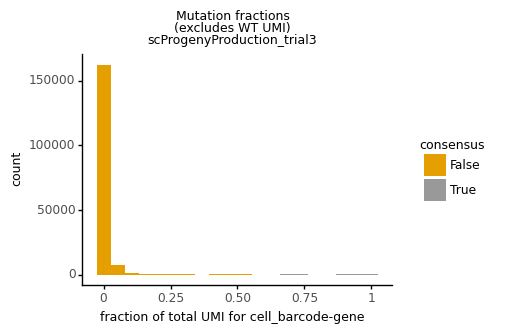

<ggplot: (8745450944136)>

In [12]:
mutation_frac_histo = (
    p9.ggplot(
        (mutation_frac_df
         [['cell_barcode', 'gene', 'mutation', 'frac_UMI', 'consensus']]
         .drop_duplicates()),
         p9.aes(x='frac_UMI',
                fill='consensus')) +
    p9.geom_histogram(bins=20) +
    p9.ggtitle('Mutation fractions\n'
               '(excludes WT UMI)\n'
               f'{expt}') +
    p9.labs(x='fraction of total UMI for cell_barcode-gene') +
    p9.theme(figure_size=(4, 3),
             plot_title=p9.element_text(size=9),
             axis_title=p9.element_text(size=9),
             legend_title=p9.element_text(size=9),
             legend_title_align='center') +
    p9.scale_fill_manual([CBPALETTE[1], CBPALETTE[0]]))

display(mutation_frac_histo)

## Merge mutatant and WT UMIs
Merge data into single dataframe, `gene_mutations`.  
Steps:  
1. Filter `mutation_frac_df` for only consensus mutations
2. Merge with `cb_gene` dataframe so every `cell_barcode-gene` has at least one row.
3. Fill `mutation` column with "WT" if a `cell_barcode-gene` does not have any consensus mutations. 

In [13]:
# Merge in consesnsus mutations
gene_mutations = pd.merge(
    left=cb_gene,
    right=mutation_frac_df.query('consensus == True'),
    on=['cell_barcode', 'gene'],
    how='left',
    validate='one_to_many'
)

# Fill mutation with WT if no consensus mutation
gene_mutations['mutation'] = (
    gene_mutations['mutation']
    .fillna('WT')
)

display(gene_mutations)

,cell_barcode,gene,mutation,mutation_UMI,total_UMI,frac_UMI,consensus
0,GCCCAGACAATTTCTC,fluNP,WT,NaN,NaN,NaN,NaN
1,GCAACATTCGTAACAC,fluNP,WT,NaN,NaN,NaN,NaN
2,CGATGCGAGATGCGAC,fluNP,WT,NaN,NaN,NaN,NaN
3,TCGGGCACACATATCG,fluNP,WT,NaN,NaN,NaN,NaN
4,TGTGGCGAGGTGATAT,fluNP,G1107A,3697.0,4456.0,0.829668,True
...,...,...,...,...,...,...,...
2983,CGTAGTAAGGCAGTCA,fluHA,WT,NaN,NaN,NaN,NaN
2984,CCTCCAAGTGCTTATG,fluHA,WT,NaN,NaN,NaN,NaN
2985,TTAGGCAAGATTGACA,fluHA,C-33T,2.0,2.0,1.000000,True
2986,AGAGAGCAGCGCGTTC,fluHA,WT,NaN,NaN,NaN,NaN


Check that every `cell_barcode-gene-UMI` is represented in final `UMI_mutations` dataframe.

In [14]:
assert len(gene_mutations[['cell_barcode', 'gene']].drop_duplicates()) == \
    len(cb_gene), "Missing cell_barcode-gene from df"

## Plot outcomes

Plot distribution of total UMI per cell_barcode-gene:

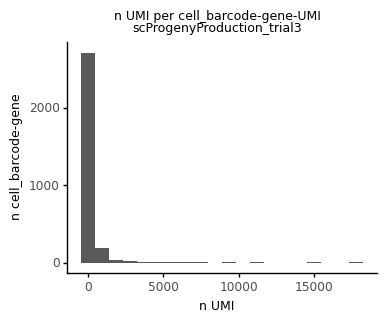

<ggplot: (8745450236299)>

In [15]:
total_UMI_histo = (
    p9.ggplot(
        (total_UMI_df),
         p9.aes(x='total_UMI')) +
    p9.geom_histogram(bins=20) +
    p9.ggtitle('n UMI per cell_barcode-gene-UMI\n'
               f'{expt}') +
    p9.labs(x='n UMI',
            y='n cell_barcode-gene') +
    p9.theme(figure_size=(4, 3),
             plot_title=p9.element_text(size=9),
             axis_title=p9.element_text(size=9),
             legend_title=p9.element_text(size=9),
             legend_title_align='center'))

display(total_UMI_histo)

Plot distribution of UMI per mutation:

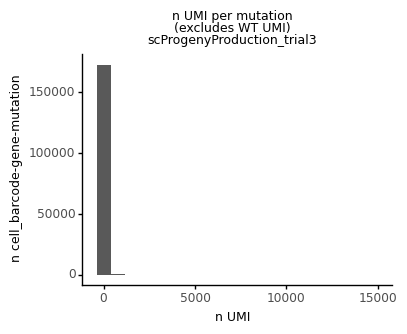

<ggplot: (8745450111585)>

In [16]:
mutation_UMI_histo = (
    p9.ggplot(
        (mutation_UMI_df
         [['cell_barcode', 'gene', 'mutation', 'mutation_UMI']]
         .drop_duplicates()),
         p9.aes(x='mutation_UMI')) +
    p9.geom_histogram(bins=20) +
    p9.ggtitle('n UMI per mutation\n'
               '(excludes WT UMI)\n'
               f'{expt}') +
    p9.labs(x='n UMI',
            y='n cell_barcode-gene-mutation') +
    p9.theme(figure_size=(4, 3),
             plot_title=p9.element_text(size=9),
             axis_title=p9.element_text(size=9),
             legend_title=p9.element_text(size=9),
             legend_title_align='center'))

display(mutation_UMI_histo)

Plot frac of UMI for each consensus mutation:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 2744 rows containing non-finite values.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


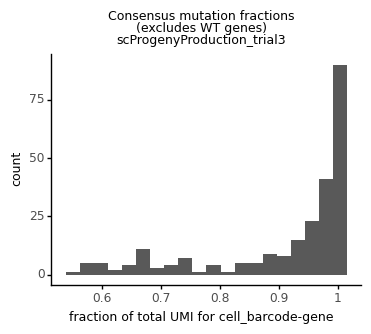

<ggplot: (8745450105095)>

In [17]:
consensus_mutations_histo = (
    p9.ggplot(
        (gene_mutations
         [['cell_barcode', 'gene', 'mutation', 'frac_UMI']]
         .drop_duplicates()),
         p9.aes(x='frac_UMI')) +
    p9.geom_histogram(bins=20) +
    p9.ggtitle('Consensus mutation fractions\n'
               '(excludes WT genes)\n'
               f'{expt}') +
    p9.labs(x='fraction of total UMI for cell_barcode-gene') +
    p9.theme(figure_size=(4, 3),
             plot_title=p9.element_text(size=9),
             axis_title=p9.element_text(size=9),
             legend_title=p9.element_text(size=9),
             legend_title_align='center') +
    p9.scale_color_manual([CBPALETTE[1], CBPALETTE[0]]))

display(consensus_mutations_histo)

## Organize output and annotate protein mutations 
Integrate mutations into genotype

In [18]:
genotypes = (
    gene_mutations
    .groupby(['cell_barcode', 'gene'])
    ['mutation']
    .unique()
    .reset_index()
    .rename(columns={'mutation': 'consensus_mutations'})
)
genotypes['consensus_mutations'] = [' '.join(map(str, l)) for l in genotypes['consensus_mutations']]

display(genotypes)

,cell_barcode,gene,consensus_mutations
0,AAACGAAGTACTTCCC,fluM,WT
1,AAACGAAGTACTTCCC,fluNA,WT
2,AAACGAAGTACTTCCC,fluNP,WT
3,AAACGAAGTACTTCCC,fluNS,WT
4,AAACGAAGTACTTCCC,fluPA,WT
...,...,...,...
2964,TTTGGAGGTATCGTTG,fluNP,WT
2965,TTTGGAGGTATCGTTG,fluNS,WT
2966,TTTGGAGGTATCGTTG,fluPA,WT
2967,TTTGGAGGTATCGTTG,fluPB1,WT


Bring in support information (total UMI per `cell_barcode-gene`):

In [19]:
output_df = pd.merge(
    left=genotypes,
    right=total_UMI_df,
    on=['cell_barcode', 'gene'],
    how='left',
    validate='one_to_one'
)

display(output_df)

,cell_barcode,gene,consensus_mutations,total_UMI
0,AAACGAAGTACTTCCC,fluM,WT,660
1,AAACGAAGTACTTCCC,fluNA,WT,152
2,AAACGAAGTACTTCCC,fluNP,WT,1169
3,AAACGAAGTACTTCCC,fluNS,WT,673
4,AAACGAAGTACTTCCC,fluPA,WT,3
...,...,...,...,...
2964,TTTGGAGGTATCGTTG,fluNP,WT,348
2965,TTTGGAGGTATCGTTG,fluNS,WT,167
2966,TTTGGAGGTATCGTTG,fluPA,WT,6
2967,TTTGGAGGTATCGTTG,fluPB1,WT,23


Annotate mutations as to synonymous / nonsynonymous:

In [52]:
viral_cds = {
    s.id: [f for f in s.features if f.type == "CDS"][0].extract(s.seq)
    for s in Bio.SeqIO.parse(viral_genbank, "genbank")
}

def annotate_mutations(row):
    gene = row["gene"]
    cds = viral_cds[gene]
    prot = str(cds.translate())
    muts = row["consensus_mutations"]
    if muts == "WT":
        return muts
    annotated_muts = []
    for mut in muts.split():
        if mut.startswith("ins") or mut.startswith("del"):
            annotated_muts.append(mut)
        else:
            wt = mut[0]
            i = int(mut[1: -1])
            m = mut[-1]
            if 1 <= i <= len(cds):
                mut_cds = list(str(cds))
                assert mut_cds[i - 1] == wt
                mut_cds[i - 1] = m
                mut_cds = Bio.Seq.Seq("".join(mut_cds))
                mut_prot = str(mut_cds.translate())
                if prot == mut_prot:
                    annotated_muts.append(f"{mut}_synonymous")
                else:
                    aamut = [
                        f"{x}{r}{y}" for r, (x, y) in enumerate(zip(prot, mut_prot), start=1) if x != y
                    ]
                    assert len(aamut) == 1
                    aamut = aamut[0]
                    annotated_muts.append(f"{mut}_{aamut}")
            else:
                annotated_muts.append(f"{mut}_noncoding")
    return " ".join(annotated_muts)


output_df = output_df.assign(
    consensus_mutations_annotated=lambda x: x.apply(annotate_mutations, axis=1)
)

output_df

,cell_barcode,gene,consensus_mutations,total_UMI,consensus_mutations_annotated
0,AAACGAAGTACTTCCC,fluM,WT,660,WT
1,AAACGAAGTACTTCCC,fluNA,WT,152,WT
2,AAACGAAGTACTTCCC,fluNP,WT,1169,WT
3,AAACGAAGTACTTCCC,fluNS,WT,673,WT
4,AAACGAAGTACTTCCC,fluPA,WT,3,WT
...,...,...,...,...,...
2964,TTTGGAGGTATCGTTG,fluNP,WT,348,WT
2965,TTTGGAGGTATCGTTG,fluNS,WT,167,WT
2966,TTTGGAGGTATCGTTG,fluPA,WT,6,WT
2967,TTTGGAGGTATCGTTG,fluPB1,WT,23,WT


Double check that every cell_barcod-gene is represented in final `output_df`

In [20]:
assert len(output_df[['cell_barcode', 'gene']].drop_duplicates()) == \
    len(cb_gene), "Missing cell_barcode-gene from df"

Make sure no na values are included in final `output_df`. Everything should either have a consensus mutation or be annotated as `"WT"`

In [21]:
assert output_df.notnull().any().any(), \
    "Found null value in output_df"

In [22]:
print(f'Saving gene consensus mutations to {consensus_gene_csv}')
output_df.to_csv(consensus_gene_csv, index=False)

Saving gene consensus mutations to results/pacbio/scProgenyProduction_trial3_consensus_gene.csv.gz
